In [1]:
import pandas as pd  
import datetime as dt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, kurtosis, skew #correlation coefficient, skewness, and kurtosis 
import seaborn as sns #used for color palletes on graphs and boxplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller # Dicky Fuller test for stationarity
import statsmodels.api as smm 
import statsmodels.formula.api as sm  # Multiple Linear Regression
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot 
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA Model import
#from pylab import rcParams # Decomposition of time series

from cleaning_functions import read_clean, expand_dates

# Reading in data from function.py

In [2]:
# Reading in new daily circulation data (covers from 2016-2023) 
egr_circ = read_clean()

### Maybe figure out how to get open hours data accounted for?

# Data exploring

In [ ]:
#Density plot (Seaborn)

plt.figure(figsize=(8, 4))
sns.kdeplot(egr_circ["transactions"], fill=True, color='green')

plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Density Plot using Seaborn')

plt.show()

In [ ]:
#Ciruclation by day over time at EGR KDL just checking out the trends and seasonality 

# Plotting the line graph with modified figure size
plt.figure(figsize=(15, 5))
plt.plot(egr_circ.index, egr_circ['transactions'])

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title('Daily Transactions Since 2016')
plt.grid(True)

# Format x-axis date labels
date_formatter = mdates.DateFormatter("%b '%y")
plt.gca().xaxis.set_major_formatter(date_formatter)

# Set a custom date locator to show every other month
month_locator = mdates.MonthLocator(interval=6)
plt.gca().xaxis.set_major_locator(month_locator)

# Fit a linear regression line (line of best fit)
x = np.arange(len(egr_circ))
y = egr_circ['transactions']
coefficients = np.polyfit(x, y, 4)  # fourth-degree polynomial
trendline = np.poly1d(coefficients)

# Plot the trendline
plt.plot(egr_circ.index, trendline(x), color='red', linestyle='--', label='Trendline')

# Adding a vertical line where we split the dataset at the beginning of 2023
plt.axvline(pd.to_datetime('01-01-2023'), color='black', linestyle='--', label='Vertical Line at x=50')

plt.show()

## Checkouts by year boxplots

In [ ]:
year = 2023

egr_circ_filtered = egr_circ[(egr_circ["year"] == year)] 

sns.boxplot(data=egr_circ_filtered, x='dayofweekchar', y='transactions', showmeans = True)

plt.xlabel(None)
plt.ylabel('Daily Transactions')
plt.title(f'Transactions by Day of Week for {year}')

plt.show()

# Time Series Forecasting

In [ ]:
#splitting the dataset into training (prior to 2023) and testing sets (after 2023)

train = egr_circ[egr_circ.index < '01-01-2023']
test = egr_circ[egr_circ.index >= '01-01-2023']

In [4]:
#Creating the model 

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'transactions'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [5]:
#Hyperparameter Grid Search

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    # Add more hyperparameters to tune as needed
}

# Create the XGBoostRegressor model
xgb_model = xgb.XGBRegressor()

# Initialize the GridSearchCV object with the model, hyperparameter grid, and scoring metric
grid_search = GridSearchCV(xgb_model, param_grid, scoring='r2', cv=5)

# Fit the GridSearchCV to find the best hyperparameters
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [8]:
#325 appears to be the sweet spot before overfitting 
XGBoost_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=400, # Number of boosting rounds orig number:325
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3, # Maximum depth of each tree
                       learning_rate=0.01) # Learning rate orig number: 0.01

#The probelm with the 'oh' error is in the fit code                        
XGBoost_reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=25)

[16:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:815.09140	validation_1-rmse:683.24297
[25]	validation_0-rmse:658.16123	validation_1-rmse:542.02649
[50]	validation_0-rmse:541.12299	validation_1-rmse:439.31817
[75]	validation_0-rmse:454.71056	validation_1-rmse:362.20960
[100]	validation_0-rmse:392.55516	validation_1-rmse:308.63032
[125]	validation_0-rmse:347.41750	validation_1-rmse:267.47375
[150]	validation_0-rmse:316.07828	validation_1-rmse:238.62177
[175]	validation_0-rmse:294.00709	validation_1-rmse:220.43886
[200]	validation_0-rmse:277.90212	validation_1-rmse:209.04292
[225]	validation_0-rmse:265.27560	validation_1-rmse:201.18551
[250]	validation_0-rmse:256.45280	validation_1-rmse:196.33773
[275]	validation_0-rmse:250.11732	validation_1-rmse:193.61009
[300]	validation_0-rmse:245.15

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

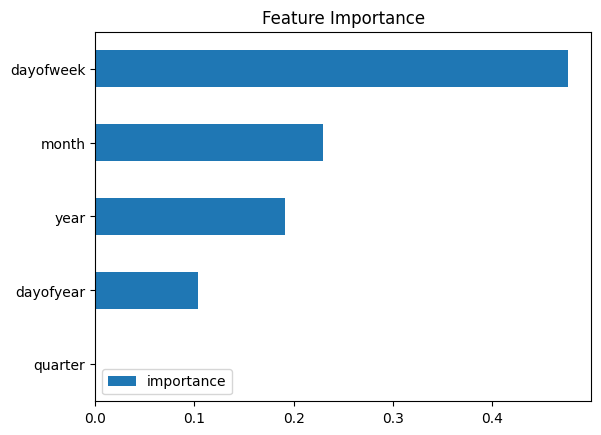

In [9]:
#Feature Importance Graph

fi = pd.DataFrame(data=XGBoost_reg.feature_importances_,
             index=XGBoost_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

              transactions  dayofweek  quarter  month  year  dayofyear  \
transactions          1.00      -0.44    -0.08  -0.08 -0.23      -0.08   
dayofweek            -0.44       1.00     0.00   0.00  0.00       0.00   
quarter              -0.08       0.00     1.00   0.97  0.00       0.97   
month                -0.08       0.00     0.97   1.00  0.00       1.00   
year                 -0.23       0.00     0.00   0.00  1.00      -0.00   
dayofyear            -0.08       0.00     0.97   1.00 -0.00       1.00   
dayofmonth           -0.01      -0.00     0.01   0.01 -0.00       0.09   
weekofyear           -0.10       0.00     0.95   0.97  0.00       0.97   

              dayofmonth  weekofyear  
transactions       -0.01       -0.10  
dayofweek          -0.00        0.00  
quarter             0.01        0.95  
month               0.01        0.97  
year               -0.00        0.00  
dayofyear           0.09        0.97  
dayofmonth          1.00        0.07  
weekofyear          0

C:\Users\Ryan\AppData\Local\Temp\ipykernel_20420\2433448971.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = egr_circ.corr()


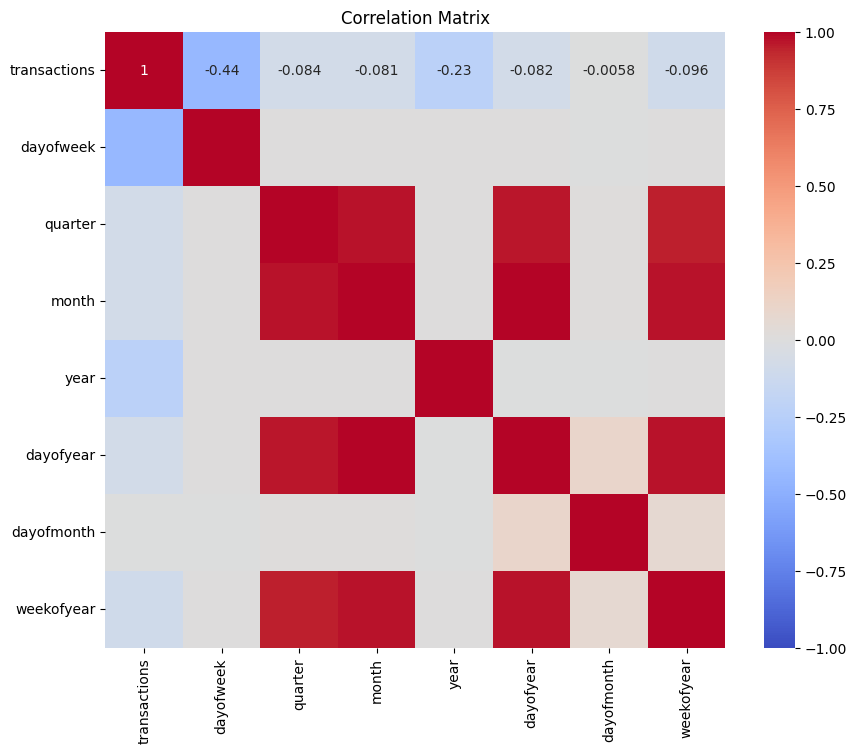

In [19]:
#Correlation matrix

# Calculate the correlation matrix
correlation_matrix = egr_circ.corr()

# Print the correlation matrix
print(np.round(correlation_matrix, decimals=2))

# Create correlation matrix plot (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [11]:
#Calculating residual mean square error 

score = np.sqrt(mean_squared_error(test['transactions'], XGBoost_reg.predict(x_test)))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 188.42


## Looking at the errors between |actual-predicted| 

In [17]:
# Data wrangling to get the predicted values for our xgb regressor model into our original 'EGR dataframes' dataset

#This is so dumb to avoid copy error BS 
test = test.copy()

# Getting the predicted values from our xgb regressor model as a np array 
test["predicted"] = np.round(XGBoost_reg.predict(x_test).astype(float), decimals = 2) #need to use np.round because reg.predict(X_test) returns a numpy array and we need to convert "predicted" to a float 64 intead of a float 32

# Merging the predicted variable from our test dataframe to into the oringal 'EGR dataframes' dataset (we can't just input the 'predicted array directly in this dataset because the oringal dataset has both training and test set)
EGR_dataframe = egr_circ.merge(test[["predicted"]], how = "left", left_index = True, right_index = True)

#Calculating the error between the predicted and actual values
EGR_dataframe["error"] = abs(EGR_dataframe["transactions"] - EGR_dataframe["predicted"])

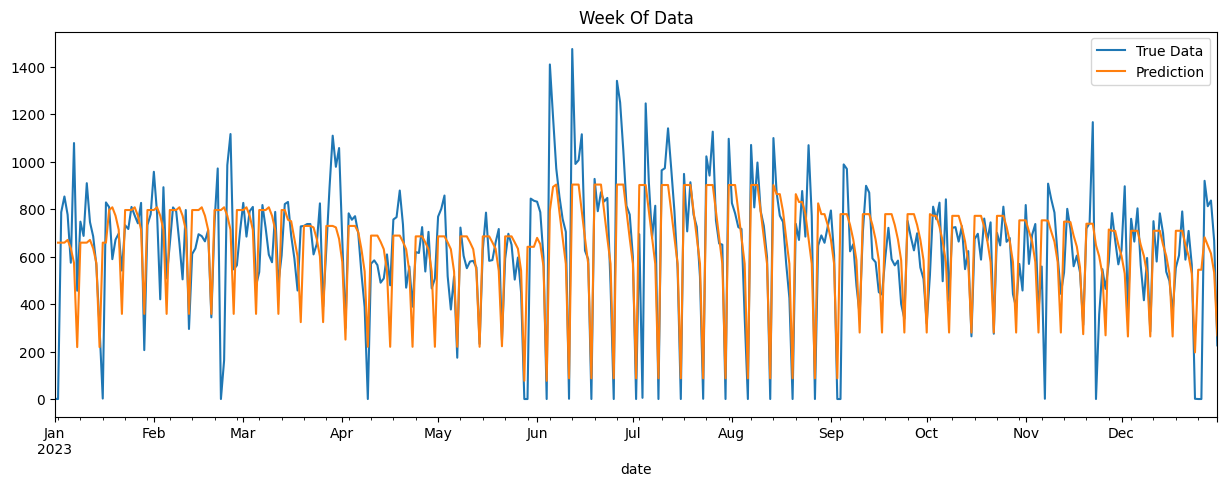

In [13]:
# plotting predicted vs actual cirulation data over time

ax = EGR_dataframe.loc[(EGR_dataframe.index >= '01-01-2023')]['transactions'] \
    .plot(figsize=(15, 5), title='Week Of Data')

EGR_dataframe.loc[(EGR_dataframe.index > '01-01-2023')]['predicted'] \
    .plot()

plt.legend(['True Data','Prediction'])
plt.show()

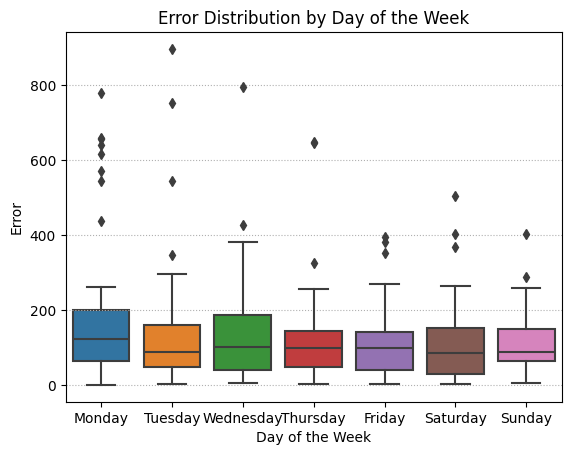

In [14]:
#Grouping the error variable by day of the week and seeing if we have trouble predicting particular days 

boxplote = sns.boxplot(x=EGR_dataframe.index.dayofweek, y=EGR_dataframe["error"])
plt.xlabel("Day of the Week")
plt.ylabel("Error")
plt.xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Error Distribution by Day of the Week")

# Adding minor ticks on the y-axis
plt.grid(axis='y', which='both', linestyle='dotted')

plt.show()

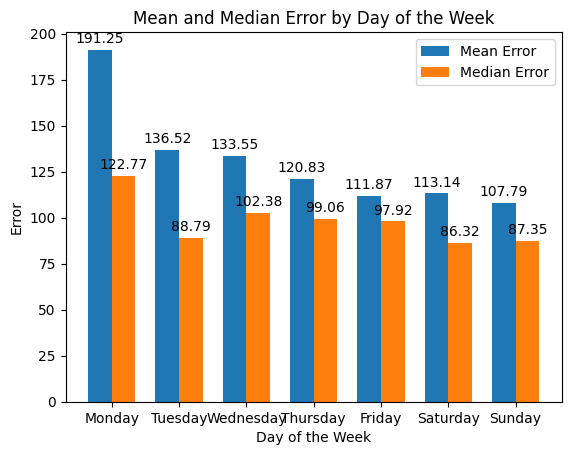

In [15]:
#In this example, I've created two grouped_data variables: grouped_data_mean and grouped_data_median. Each variable represents the mean and median error values grouped by the day of the week.
#The bar chart is created using plt.bar(). By specifying different x-coordinates for the mean and median bars (index and index + bar_width), the bars are displayed side by side. The legend is used to differentiate between the mean and median error bars.
#To display the values on top of each bar, I've used the annotate() function to add text annotations. The height of each bar is extracted using rect.get_height() and displayed with two decimal places.

# Grouping the error variable by the day of the week
grouped_data_mean = EGR_dataframe.groupby(EGR_dataframe.index.dayofweek)["error"].mean()
grouped_data_median = EGR_dataframe.groupby(EGR_dataframe.index.dayofweek)["error"].median()

# Creating a bar chart
bar_width = 0.35
index = np.arange(7)

fig, ax = plt.subplots()
rects1 = ax.bar(index, grouped_data_mean, bar_width, label='Mean Error')
rects2 = ax.bar(index + bar_width, grouped_data_median, bar_width, label='Median Error')

# X-axis labels and ticks
plt.xlabel("Day of the Week")
plt.ylabel("Error")
plt.xticks(index + bar_width/2, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Mean and Median Error by Day of the Week")
plt.legend()

# Displaying the values on top of the bars
for rect in rects1+rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.show()